# MNIST

Classification of hand written digits from MNIST [dataset](http://yann.lecun.com/exdb/mnist/) using CNN - PyTorch framework!

In [1]:
#Metadata
%load_ext watermark
%watermark -a "Vutsal Singhal" -p numpy,matplotlib,torch -u -n -t -z -m

Vutsal Singhal 
last updated: Tue Jan 16 2018 11:04:18 EST

numpy 1.13.3
matplotlib 2.1.0
torch 0.3.0.post4

compiler   : GCC 5.4.0 20160609
system     : Linux
release    : 4.13.0-26-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

## Training settings

In [9]:
use_cuda = True
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=True, download=True,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
        batch_size=64, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', train=False,
            transform=torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
        batch_size=1000, shuffle=True, **kwargs)

## Display samples from dataset

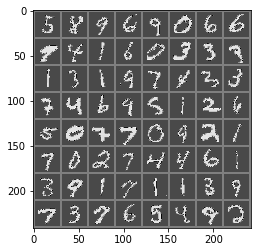

Labels:
 [[5 8 9 6 9 0 6 6]
 [9 4 1 6 0 3 3 3]
 [1 3 1 9 7 4 3 3]
 [7 4 6 9 5 1 2 6]
 [5 0 7 7 0 9 2 1]
 [7 0 2 7 4 4 6 1]
 [3 9 1 7 1 1 3 9]
 [7 3 7 6 5 4 9 2]]

Individual image:


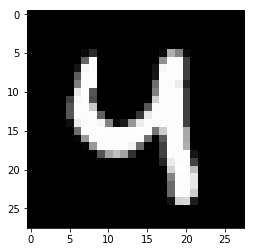

	Label: 4


In [12]:
def imshow(img):
    img   = img/2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Labels:\n',labels.numpy().reshape(8,8))

print('\nIndividual image:')
img = images[25].numpy().reshape(28,28)
plt.imshow(img,cmap='gray')
plt.show()
print('\tLabel:',labels[25])

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

model = Net()
if use_cuda:
    model.cuda()

In [87]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

def train(epoch):
    #model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()           # Clear gradients
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [85]:
def test():
    #model.eval()
    correct   = 0
    test_loss = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [86]:
for epoch in range(1,10+1):  # Epochs: 10
    train(epoch)
    test()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.163146
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.045152
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.045291
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.032305
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.092964
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.080628
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.121966
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.076449
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.043870
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.065216
Test set: Average loss: 0.1051, Accuracy: 9682/10000 (96.820%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.352407
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.078176
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.072829
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.029058
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.096102
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.019915
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.024045
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.015159
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.15163